# Forecasting
______________________________________________________

### Import Relevant Packages

In [92]:
# Package Importation
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from datetime import date, timedelta
import requests
import bs4 as bs
import pickle
from os import listdir
import quandl
import tensorflow as tf
from math import floor
from sklearn.preprocessing import MinMaxScaler

'''
# Input functions from other notebook
import import_ipynb
from functions_1 import *
'''

# Import API keys
from API_keys import Quandl_api_key, AlphaVantage_api_key

# Check versions
print('python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas_datareader: {}'.format(pdr.__version__))
print('requests: {}'.format(requests.__version__))
print('bs4: {}'.format(bs.__version__))
print('tensorflow: {}'.format(tf.version.VERSION))

%matplotlib inline

# Quandl API Configuration
quandl.ApiConfig.api_key = Quandl_api_key

python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas: 0.25.1
numpy: 1.16.5
pandas_datareader: 0.8.1
requests: 2.22.0
bs4: 4.8.0
tensorflow: 2.0.0


### Functions to Import Ticker and S&P 500 Price/ Volume Data

In [23]:
# Pull Tickers
def sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rstrip('\n'))
        
    with open("Forecasting_Exp_1_Data\sp500_tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

def sp500_yahoo(tickers, start, end):
    yahoo_df = pd.DataFrame()
    date_string = '_from_' + str(start) + '_to_' + str(end)

    for i, ticker in enumerate(tickers):
        print("Collecting Yahoo data ", str(i+1), " of ", str(len(tickers)), ": ", ticker)
        try:
            ticker_data = pdr.get_data_yahoo(symbols=ticker, start=start, end=end)
            ticker_data['Ticker'] = ticker
            ticker_data.reset_index(inplace=True,drop=False)
            yahoo_df = yahoo_df.append(ticker_data)

        except:
            print("Exception")
            continue
            
    pickle_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(yahoo_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.xlsx'
    yahoo_df.to_excel(excel_save_path)

    return yahoo_df


###  Functions to Import Quandl Data

In [24]:
def get_sentiment(start, end):
    date_string = '_from_' + str(start) + '_to_' + str(end)

    sent_df = pd.DataFrame(quandl.get('AAII/AAII_SENTIMENT', start_date=start, end_date=end))
    sent_df.reset_index(inplace=True,drop=False)

    pickle_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(sent_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.xlsx'
    sent_df.to_excel(excel_save_path)
    return quandl.get('AAII/AAII_SENTIMENT', start_date=start, end_date=end)


### Functions to Update Data Dictionary (Local Datasets)

In [25]:
# Update local datasets
def update_data(start, end, overwrite_all = 0):
    '''
    Input: Dictionary of All Datasets
    Returns: Updated Data, or saved data
    '''
    date_string = '_from_' + str(start) + '_to_' + str(end)

    stored_files = listdir('Forecasting_Exp_1_Data')
    print("Stored files: ", stored_files)
    
    data_dict = {}
    
    # Add sp500 tickers
    if ('sp500_tickers.pickle' in stored_files) and (overwrite_all == 0):
        print('Loading Tickers from file')
        with open('Forecasting_Exp_1_Data\sp500_tickers.pickle', 'rb') as f:
            data_dict['sp500_tickers'] = pickle.load(f)
    else:
        print('Pulling Tickers from web')
        data_dict['sp500_tickers'] = sp500_tickers()

    # Add yahoo data
    pickle_yahoo_path = "sp500_yahoo" + date_string + ".pickle"
    pickle_yahoo_dir_path = "Forecasting_Exp_1_Data\sp500_yahoo" + date_string + ".pickle"
    if (pickle_yahoo_path in stored_files) and (overwrite_all == 0):
        print('Loading Yahoo price data from file')
        with open(pickle_yahoo_dir_path, 'rb') as f:
            data_dict['sp500_yahoo'] = pickle.load(f)
    else:
        print('Pulling Yahoo price data from web')
        data_dict['sp500_yahoo'] = sp500_yahoo(data_dict['sp500_tickers'], start, end)
    
    # Add sentiment Data
    pickle_sent_path = "sentiment" + date_string + ".pickle"
    pickle_sent_dir_path = "Forecasting_Exp_1_Data\sentiment" + date_string + ".pickle"
    if (pickle_sent_path in stored_files) and (overwrite_all == 0):
        print('Loading sentiment data from file')
        with open(pickle_sent_dir_path, 'rb') as f:
            data_dict['sentiment'] = pickle.load(f)
    else:
        print('Pulling sentiment data from web')
        data_dict['sentiment'] = get_sentiment(start, end)
        
    return data_dict

### Helper Functions

In [158]:
def splitter(df_series, train_percent, num_folds):
    
    """
    Input: df_series as [type] pandas.core.series.Series
    Input: train_percent as [type] float
    Returns: tuple of fold lists, train lists and test lists
    """
    
    series_length = len(df_series)
    splits = np.linspace(0, series_length, num_folds + 1, endpoint = True, dtype=int)
        
    train_list = []
    test_list = []
    fold_list = []
    
    for index, value in enumerate(splits):
        if index == 0:
            continue
        
        fold = df_series[splits[index-1]:splits[index]]
        fold_list.append(fold)
        fold_len = len(fold)
        train_list.append(fold[:floor(train_percent*fold_len)])
        test_list.append(fold[floor(train_percent*fold_len):])
    
    return(fold_list, train_list, test_list)
    
def smoother_scaler(train_data, test_data, EMA, gamma):
    scaler = MinMaxScaler()
    train_data = np.asarray(train_data).reshape(-1, 1)
    test_data = np.asarray(test_data).reshape(-1, 1)
    
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
 
    # Reshape both train and test data
    train_data = train_data.reshape(-1)

    # Normalize test data
    test_data = scaler.transform(test_data).reshape(-1)
    
    # Now perform exponential moving average smoothing
    # So the data will have a smoother curve than the original ragged data
    for ti in range(len(train_data)):
        EMA = gamma*train_data[ti] + (1-gamma)*EMA
        train_data[ti] = EMA
    
    return (train_data, test_data)


### Neural Network Construction

### Initial Commands

In [127]:
# Date information
today = date.today()
year_ago = today - timedelta(days=365)

# Pull Stock Data
print("Pulling data from ", year_ago, " to ", today)

data_dict = update_data(start=year_ago, end=today, overwrite_all = 0)


Pulling data from  2018-12-14  to  2019-12-14
Stored files:  ['sentiment_from_2018-12-14_to_2019-12-14.pickle', 'sentiment_from_2018-12-14_to_2019-12-14.xlsx', 'sp500_tickers.pickle', 'sp500_yahoo_from_2018-12-14_to_2019-12-14.pickle', 'sp500_yahoo_from_2018-12-14_to_2019-12-14.xlsx']
Loading Tickers from file
Loading Yahoo price data from file
Loading sentiment data from file


### Visualization

In [136]:
AAL_df = data_dict["sp500_yahoo"].loc[data_dict["sp500_yahoo"]['Ticker'] == 'AAL']
AAL_df.reset_index(inplace=True,drop=False)

sent_df = data_dict["sentiment"]
sent_df.reset_index(inplace=True,drop=False)

<Figure size 432x288 with 0 Axes>

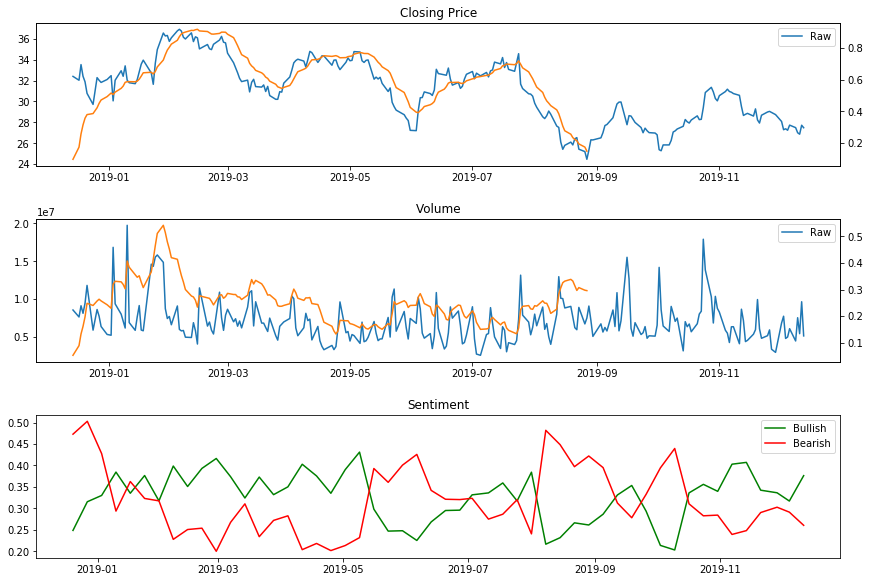

In [163]:
# Before normalization/ smoothing

AAL_close = AAL_df['Close']
AAL_date = AAL_df['Date']
AAL_vol = AAL_df['Volume']

sent_date = sent_df['Date']
sent_bull = sent_df['Bullish']
sent_bear = sent_df['Bearish']

'''
plt.figure(1)
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].plot(AAL_date, AAL_close)
axs[1].plot(AAL_date, AAL_vol)
axs[2].plot(sent_date, sent_bull, label = "Bullish", color='g')
axs[2].plot(sent_date, sent_bear, label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Volume")
axs[2].set_title("Sentiment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
axs[2].legend()
'''

# After normalization/ smoothing

AAL_close_fold_list, AAL_close_train_list, AAL_close_test_list = splitter(AAL_close, 0.7, 1)
AAL_date_fold_list, AAL_date_train_list, AAL_date_test_list = splitter(AAL_date, 0.7, 1)
AAL_vol_fold_list, AAL_vol_train_list, AAL_vol_test_list = splitter(AAL_vol, 0.7, 1)


AAL_close_train_list = AAL_close_train_list[0]      
AAL_close_test_list =  AAL_close_test_list[0]
AAL_date_train_list = AAL_date_train_list[0]
AAL_date_test_list = AAL_date_test_list[0]
AAL_vol_train_list = AAL_vol_train_list[0]
AAL_vol_test_list = AAL_vol_test_list[0]

EMA = 0.0
gamma = 0.15

AAL_close_train_sm, AAL_close_test_sm = smoother_scaler(AAL_close_train_list, AAL_close_test_list, EMA, gamma)
AAL_vol_train_sm, AAL_vol_test_sm = smoother_scaler(AAL_vol_train_list, AAL_vol_test_list, EMA, gamma)

'''
plt.figure(2)
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].plot(AAL_date_train_list, AAL_close_train_sm)
axs[1].plot(AAL_date_train_list, AAL_vol_train_sm)
#axs[2].plot(sent_date, sent_bull, label = "Bullish", color='g')
#axs[2].plot(sent_date, sent_bear, label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Volume")
#axs[2].set_title("Sentiment")
'''

plt.figure(3)
fig, axs = plt.subplots(3, 1, figsize=(12,8))

axs[0].plot(AAL_date, AAL_close, label = "Raw", c = 'tab:blue')
axs01 = axs[0].twinx()  
axs01.plot(AAL_date_train_list, AAL_close_train_sm, label = "Smoothed", c = 'tab:orange')

axs[1].plot(AAL_date, AAL_vol, label = "Raw", c = 'tab:blue')
axs11 = axs[1].twinx()
axs11.plot(AAL_date_train_list, AAL_vol_train_sm, label = "Smoothed", c = 'tab:orange')

axs[2].plot(sent_date, sent_bull, label = "Bullish", color='g')
axs[2].plot(sent_date, sent_bear, label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Volume")
axs[2].set_title("Sentiment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

axs[0].legend()
axs[1].legend()
axs[2].legend()
